In [1]:
import torch
from torch.utils.data import dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
import numpy as np
import cv2 
import os,sys
import pandas as pd
import tqdm
from PIL import Image
from early_stopping import EarlyStopping

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

columns_selected = ['领围', '胸围', '中腰围', '腹围', '裤腰围', '臀围', '腿根围', '通裆',
                    '上臂围', '左腕围', '右腕围', '总肩宽', '前肩宽', '右袖长', '左袖长',
                    '后腰节长', '衬衣后衣长', '西服后衣长',  '前腰节长', '裤长', '腰膝长',
                    '膝围', '腿肚围']

Weight_matrix = pd.read_excel('./data/weight_embedding_matrix_224.xls', index_col=0)
correct_index = [round(i, 2) for i in Weight_matrix.index]
Weight_matrix.index = correct_index

Weight_matrix.shape

(1951, 224)

In [4]:
imgs_path = './data/complete_body_contour_scaled_3part'
real_size = pd.read_excel('./data/client_size_23_2_10.xls')

res = {}
for filename in os.listdir(imgs_path):
    client_id = filename.split("_")[0]
    if int(client_id) not in res:
        res[int(client_id)] = []
    res[int(client_id)].append(filename)

cnt = 0
bad_sample = []
for key in res:
    if len(res[key]) != 10:
        bad_sample.append(key)
        cnt += 1       
print(cnt,len(bad_sample))

for filename in os.listdir(imgs_path):
    client_id = filename.split("_")[0]
    if int(client_id) in bad_sample:
        os.remove(os.path.join(imgs_path, filename))
        print(os.path.join(imgs_path, filename), "is removed.")

# print("before: ", len(res))
# for key in bad_sample:
#     res.pop(key)
# print("after: ", len(res))

# data = real_size[real_size['用户编号'].isin(res.keys())]

# fo = open("./data/client_ids_3part.txt","w")
# for i in range(data.shape[0]):
#     client_id = data.iloc[i]["用户编号"]
#     sizes = ",".join([str(item) for item in data.iloc[i][columns_selected].values])
#     fo.write("%s\t%s\n"%(client_id,sizes))
# fo.close()

0 0


In [3]:
len(res)

15960

In [7]:
def prepare_data():
    client_ids_path = './data/client_ids_3part.txt'
    imgs_path = './data/complete_body_contour_scaled_3part'
    real_size = pd.read_excel('./data/client_size_23_2_10.xls')
    # X, Y, client_ids = data_preprocess(client_ids_path, imgs_path)
    client_ids = []
    client_sizes = []
    with open(client_ids_path, "r") as file:
        lines = file.readlines()
        # for i in tqdm.tqdm(range(len(lines))):
        for line in tqdm.tqdm(lines):
            # line = lines[i]
            line = line.strip().split("\t")
            if len(line) < 2:
                continue
            client_id = line[0]
            data = line[1]
            client_sizes.append(np.array(data.split(","), dtype=np.float32))
            client_ids.append(int(client_id))

    # 筛选出男性数据
    res = real_size[(real_size['用户编号'].isin(client_ids))&(real_size['性别']=="男")]
    num_all = res.shape[0]
    num_train = int(0.8*num_all)
    num_validate = int(0.1*num_all)
    num_test = num_all - num_train - num_validate
    print("total number: ", num_all)
    res.iloc[:num_train].sample(frac=1).to_csv("./data/client_size_train.csv",index=None)
    res.iloc[num_train:num_train+num_test].sample(frac=1).to_csv("./data/client_size_validation.csv",index=None)
    res.iloc[num_train+num_test:].sample(frac=1).to_csv("./data/client_size_test.csv",index=None)
    print("train number: ", num_train, "validate number: ", num_validate, "test number: ", num_test)
prepare_data()

100%|██████████| 15960/15960 [00:00<00:00, 534750.14it/s]

total number:  14242
train number:  11393 validate number:  1424 test number:  1425


### 转成灰度图

In [25]:
def convert_to_grayscale(image_path):
    image = Image.open(image_path).convert("L")
    dirname = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    save_path = os.path.join(dirname, filename.split(".")[0]+"_gray.png")
    image.save(save_path)

def convert_images(imgs_path):
     for filename in tqdm.tqdm(os.listdir(imgs_path)):
        image_path = os.path.join(imgs_path, filename)
        convert_to_grayscale(image_path)
     
# convert_images(imgs_path)

100%|██████████| 64930/64930 [26:27<00:00, 40.91it/s]


### 切割成正方形

In [26]:
from torchvision import transforms
from PIL import Image
import tqdm

# 定义预处理操作
preprocess = transforms.Compose([
    # transforms.Resize((256, 192)),
    transforms.CenterCrop((1536, 1536)),
    transforms.Resize((224, 224)),
])
  
for filename in tqdm.tqdm(os.listdir(imgs_path)):
    if "_modnet_morphology_canny_gray.png" not in filename:
        continue
    image_path = os.path.join(imgs_path, filename)
    image = Image.open(image_path)
    cropped_image = preprocess(image)
    save_path = os.path.join(imgs_path, filename.split(".")[0]+"_cropped.png")
    cropped_image.save(save_path)

100%|██████████| 129860/129860 [02:57<00:00, 732.13it/s]


In [32]:
from matplotlib import pyplot as plt
path = imgs_path + "/10001035_0_modnet_morphology_canny_gray_cropped.png"

img = plt.imread(path)
img.shape

(224, 224)

In [8]:
class LoadData(dataset.Dataset):
    
    def __init__(self, client_size_path, imgs_path):
        super(LoadData, self).__init__()
        self.data = self.__load_data__(client_size_path, imgs_path)
    
    def __getitem__(self, index):
        image, size = self.data[index]
        return image, size
    
    def __len__(self):
        return len(self.data)

    def __load_data__(self,client_size_path, imgs_path):
        size_data = pd.read_csv(client_size_path)
        client_sizes = size_data[columns_selected].values
        imgs = []
    
        for client_id in tqdm.tqdm(size_data['用户编号']):
            imglist = []
            p3 = '_0_modnet_morphology_canny_gray_cropped.png'
            p4 = '_1_modnet_morphology_canny_gray_cropped.png'
            for j in [p3, p4]:
                filename = str(client_id) + j
                path = os.path.join(imgs_path, filename)
                img = plt.imread(path)
                img_ = np.expand_dims(img, axis=0).astype(np.float32)
                imglist.append(img_)
            weight = float(size_data[size_data['用户编号'].astype(int) == int(client_id)]['体重'].iloc[0])
            We = np.array(Weight_matrix.loc[weight])[None, :]
            We = np.expand_dims(np.tile(We, (224, 1)), axis=0).astype(np.float32)
            # 将体重信息作为单独一个通道
            imglist.append(We)
            img1 = np.concatenate(imglist, axis=0)
            imgs.append(img1)
        
        return list(zip(imgs,client_sizes))

In [16]:
imgs_path = './data/complete_body_contour_scaled_3part'
client_size_train = "./data/client_size_train.csv"
client_size_validation = "./data/client_size_validation.csv"
client_size_test = "./data/client_size_test.csv"

train_dataset = LoadData(client_size_train,imgs_path)
validation_dataset = LoadData(client_size_validation,imgs_path)
test_dataset = LoadData(client_size_test,imgs_path)

batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/11393 [00:00<?, ?it/s]

100%|██████████| 1424/1424 [00:00<00:00, 1613.79it/s]


In [19]:
# for step, (img, size) in enumerate(train_loader):
#     print('step is :', step)
#     print(img.shape)
#     break

In [17]:
num_classes = 23

# resnet
# model = models.resnet50(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# densenet
# model = models.densenet121(pretrained=False)
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, num_classes)

# vit
model = models.vit_b_16(pretrained=False)
num_ftrs = model.heads.head.in_features
model.heads.head = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0') # 默认使用 GPU
model = model.to(device)
model.cuda()

/home/lei/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lei/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [18]:
# Hyper-parameters
num_epochs = 50
learning_rate = 0.0001

In [19]:
train_losses = []
eval_losses = []

save_path = "./check_points" #当前目录下
early_stopping = EarlyStopping(save_path,patience=20)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    train_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        sizes = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.float(), sizes.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        
        # if (i+1) % 100 == 0:
        #     print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    train_losses.append(train_loss/total_step)
           
    # validate the model
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        res = []
        for images, sizes in validation_loader:
            images = images.to(device)
            sizes = sizes.to(device)
            outputs = model(images)
            loss = criterion(outputs.float(), sizes.float())
            
            eval_loss += loss.item()
            
    eval_losses.append(eval_loss/len(validation_loader))
    
    print ("Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, num_epochs, train_loss/total_step, eval_loss/len(validation_loader)))
    
    # 早停止
    # early_stopping(eval_loss, model)
    # #达到早停止条件时，early_stop会被置为True
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break #跳出迭代，结束训练

Epoch [1/50], Training Loss: 2563.3729, Validation Loss: 1459.8548
Epoch [2/50], Training Loss: 826.4945, Validation Loss: 408.9356
Epoch [3/50], Training Loss: 210.7206, Validation Loss: 98.9493
Epoch [4/50], Training Loss: 52.3689, Validation Loss: 31.7649
Epoch [5/50], Training Loss: 21.3168, Validation Loss: 18.1459
Epoch [6/50], Training Loss: 14.6323, Validation Loss: 14.0048
Epoch [7/50], Training Loss: 12.2893, Validation Loss: 13.2737
Epoch [8/50], Training Loss: 11.6103, Validation Loss: 11.4760
Epoch [9/50], Training Loss: 11.1137, Validation Loss: 10.6806
Epoch [10/50], Training Loss: 10.3947, Validation Loss: 10.5646
Epoch [11/50], Training Loss: 10.2147, Validation Loss: 9.9577
Epoch [12/50], Training Loss: 9.9516, Validation Loss: 9.7102
Epoch [13/50], Training Loss: 9.6335, Validation Loss: 9.4370
Epoch [14/50], Training Loss: 9.4090, Validation Loss: 9.3356
Epoch [15/50], Training Loss: 9.5409, Validation Loss: 9.3294
Epoch [16/50], Training Loss: 9.9051, Validation Lo

In [20]:
# Test the model
model.eval()
with torch.no_grad():
    res = []
    for images, sizes in test_loader:
        images = images.to(device)
        sizes = sizes.to(device)
        outputs = model(images)
        err = np.array(100*((outputs-sizes).abs()/sizes).cpu())
        res.extend(err)

In [21]:
def error_plot(res, title):
    avg = np.array(res).mean(axis=0)
    std = np.array(res).std()
    r1 = avg + std #上方差
    r2 = avg - std #下方差

    # 带方差的折线图
    plt.figure(figsize=(12,10))
    plt.plot(range(len(avg)), avg, "-or",linewidth=2.0, label='mean relative error')
    plt.fill_between(range(len(avg)), r1, r2, color='blue', alpha=0.2)
    plt.xticks(range(len(avg)),columns_selected,fontsize=14, rotation=45)
    plt.ylabel("error(%)",fontsize=14)
    plt.legend(fontsize=14)
    plt.title(title)
    plt.grid(True)
    plt.savefig("./result/mean_relative_error_%s"%title, dpi=300)

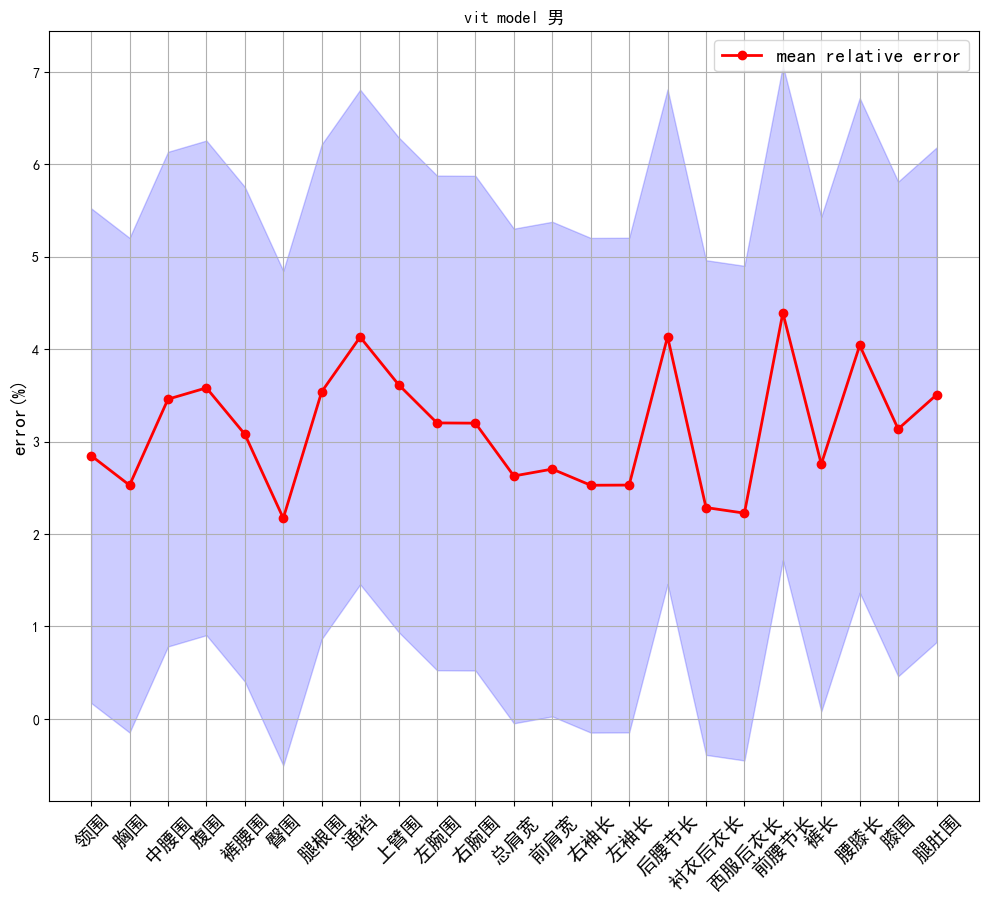

In [22]:
error_plot(res, "vit model 男")

In [52]:
def error_plot(ave_err,model_name):
    fig = plt.figure(figsize=(8,6))
    plt.plot(range(len(ave_err)),ave_err,"-o")
    plt.xticks(range(len(ave_err)),columns_selected,fontsize=10, rotation=45)
    plt.ylabel("error(%)",fontsize=14)
    plt.title(model_name)

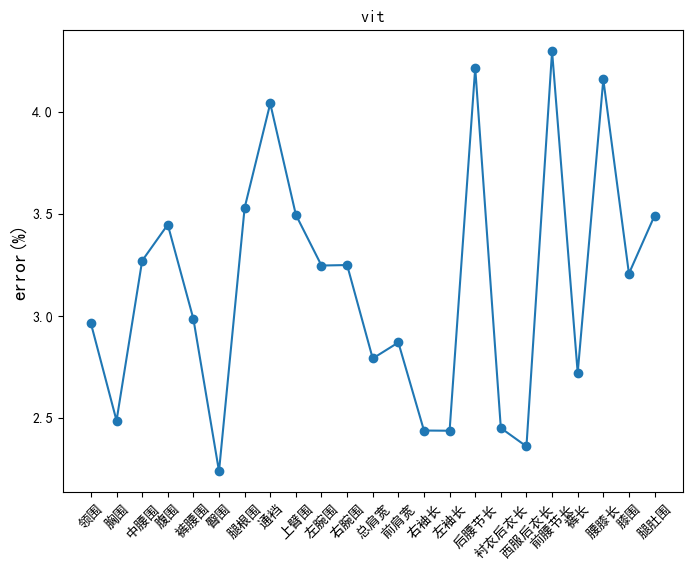

In [53]:
ave_err = np.array(res).mean(axis=0)
error_plot(ave_err, "vit")

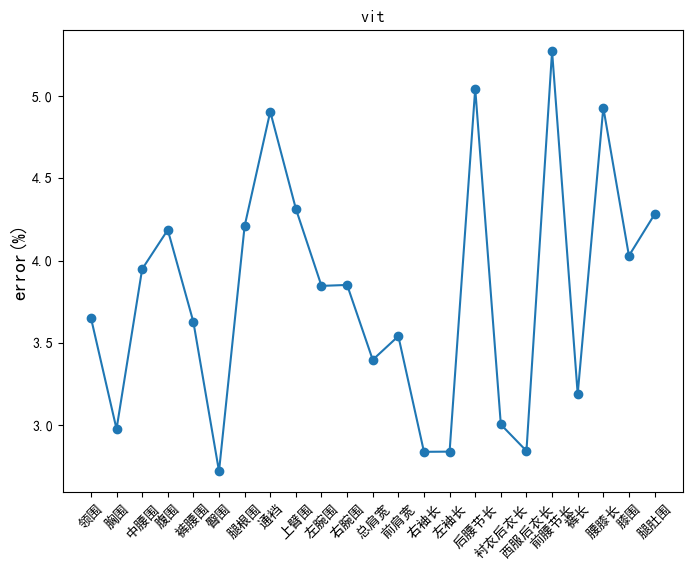

In [47]:
ave_err = np.array(res).mean(axis=0)
error_plot(ave_err, "vit")

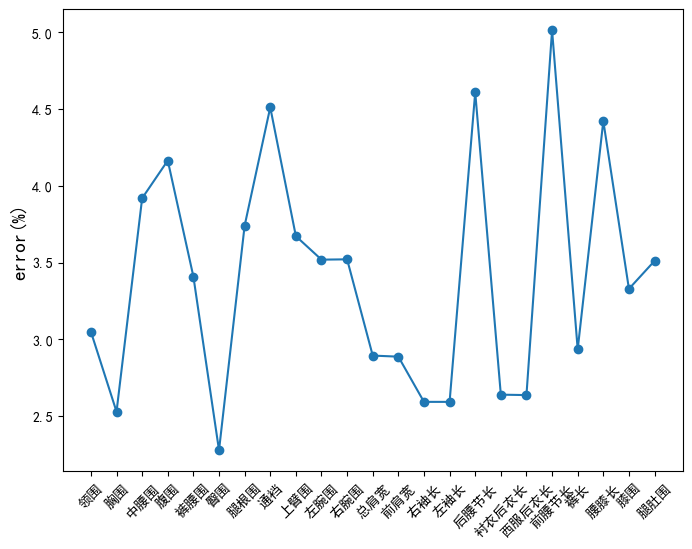

In [25]:
ave_err = np.array(res).mean(axis=0)
error_plot(ave_err)

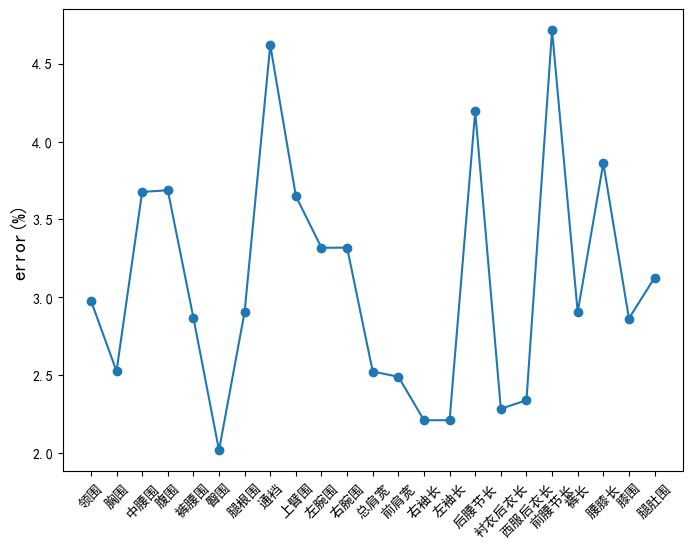

In [ ]:
ave_err = np.array(res).mean(axis=0)
error_plot(ave_err)

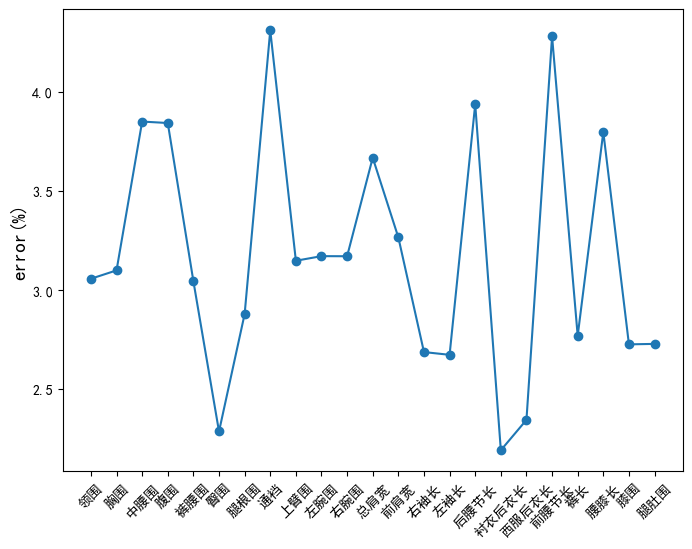

In [14]:
ave_err = np.array(res).mean(axis=0)
error_plot(ave_err)

In [ ]:
import datetime
 
current_date = datetime.date.today()
formatted_date = current_date.strftime("%Y-%m-%d")

# Save the model checkpoint
torch.save(model.state_dict(), './save_model/resnet_%s.ckpt'%formatted_date)